# Modelo Random Forest (RAF) 



En este cuaderno de Jupyter se construye el modelo Random Forest usando los hiperparámetros calculados en el cuaderno `hiperparamtros_RAF.ipynb` 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os

# Escalamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# modelo RAF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

## Lectura de datasets 

In [2]:
# Nombre de las acciones
tickers = [
    'TSCO', 'AZN', 'BARC', 'BP', 'BATS', 'HLMA',
    'HSBA', 'JMAT', 'LGEN', 'MKS', 'PSON', 'REL',
    'NWG', 'SHEL', 'SGE', 'SBRY', 'SDR', 'SVT',
    'SMIN', 'SSE', 'VOD'
]

data_frames = {} # Inicializo diciconario de data frames

for ticker in tickers: 
    
    df = pd.read_csv(f'datasets_features/{ticker}.csv')  # leo el dataset
    data_frames[ticker] = df                             # guardo dataframes
    
print(data_frames.keys())

dict_keys(['TSCO', 'AZN', 'BARC', 'BP', 'BATS', 'HLMA', 'HSBA', 'JMAT', 'LGEN', 'MKS', 'PSON', 'REL', 'NWG', 'SHEL', 'SGE', 'SBRY', 'SDR', 'SVT', 'SMIN', 'SSE', 'VOD'])


## Función para 1 bloque - 1 acción 

In [3]:
def modelo_RAF(df_bloque, model):
    '''
    Dado un bloque de 1000 días, esta función usa el 'Modelo Random Forest' para predecir. 
    Parametros:
    -----------
        df_bloque : pd.DataFrame con bloque de 1000 días. 
            Contiene los 20 features + (open, close, high, low,...)
        model : modelo a aplicar
    
    Return:
    -------
        diccionario : devuelve un diccionario con los resultados de prediciones y metricas. 
            Tiene como claves: y_pred, y_test, y_pred_s, y_test_s, y_pre_close, y_test_close, metrics
    
    '''
    
    # 1) ------------- Partición de datos ---------------- 
    
    df_features = df_bloque.drop(columns=['Date', 'Open', 'High', 'Low','Close','Volume', 'prev_close', 'target']) # todas columnas r_i
    target      = df_bloque['target']  # columna del target
    close       = df_bloque['Close']   # columna precio cierre
    
    ini_train, fin_train = 0, 749 
    ini_test, fin_test = 750, 999 
    
    X_train = df_features.iloc[ : fin_train + 1]
    X_test  = df_features.iloc[ini_test : fin_test + 1]
    y_train = target.iloc[ : fin_train + 1]
    y_test  = target.iloc[ini_test : fin_test + 1]
    y_test_close = close.iloc[ini_test : fin_test + 1]

    # 2) ----------- Estandarización ---------------------
    # Features 
    scaler_x = MinMaxScaler(feature_range=(-1,1))
    X_train_s = scaler_x.fit_transform(X_train)     
    X_test_s  = scaler_x.transform(X_test)

    # Target (al estandarizar son 2D)
    scaler_y = MinMaxScaler(feature_range=(-1,1))
    y_train_s = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel() # Necesario reshape, scaler espera 2D      
    y_test_s  = scaler_y.transform(y_test.values.reshape(-1, 1))

    # 3) ---------- Entrenamiento y predicción del modelo --------------------
    
    model.fit(X_train_s, y_train_s)
    y_pred_s = model.predict(X=X_test_s)
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1, 1)).ravel() 
    
    # en caso de no estandarizar
    #model.fit(X_train, y_train)
    #y_pred = model.predict(X=X_test)

    
    # Predicción de los precios   
    P_real_test = close.iloc[ini_test : fin_test+1]  # 250 precios: desde P_750 hasta P_999
    y_pred_close = np.zeros(249)                # 249 predicciones de P_close: desde P_751 hasta P_999

    for k in range(len(y_pred_close)): 
        y_pred_close[k] = P_real_test.iloc[k]*np.exp(y_pred[k])  
        # ojo: las predicciones y_pred_close = [P_751, P_752, ... , P_999] 
        # empiezan en 751 porque P_750 ya lo conozco al disponer de y_749
    
    
    # 4) ---------- Cálculo de métricas ------------------
    mse   = mean_squared_error(y_true = y_test, y_pred = y_pred)     
    mse_s = mean_squared_error(y_true = y_test_s, y_pred = y_pred_s)
    rmse   = np.sqrt(mse)
    rmse_s = np.sqrt(mse_s)
    mae   = mean_absolute_error(y_true = y_test, y_pred = y_pred)
    mae_s = mean_absolute_error(y_true = y_test_s, y_pred = y_pred_s)
    r2   = r2_score(y_true = y_test, y_pred = y_pred)
    r2_s = r2_score(y_true = y_test_s, y_pred = y_pred_s)
    
    #print('Precios reales:\n', close.iloc[745:753])
    #print('Predicciones de precio desde P_751...P_999:\n', y_pred_close[0:5])
    
    # --------------- Returns ---------------------
    diccionario = {}
    diccionario['y_pred'] = y_pred
    diccionario['y_test'] = y_test.values
    diccionario['y_pred_s'] = y_pred_s
    diccionario['y_test_s'] = y_test_s
    diccionario['metrics'] = {'mse':mse, 'rmse':rmse, 'mae':mae, 'r2':r2}
    diccionario['metrics_s'] = {'mse_s':mse_s, 'rmse_s':rmse_s, 'mae_s':mae_s, 'r2_s':r2_s}
    
    # para los gráficos del Precio cierre 
    diccionario['y_pred_close'] = y_pred_close
    diccionario['y_test_close'] = close.iloc[ini_test+1 : fin_test+1].values # 249 valores [P_751,...,P_999]
    
    
    return diccionario 


## Construcción del modelo 

In [4]:
#Construyo modelo 
RAF_model = RandomForestRegressor(
            n_estimators = 150,  #100
            criterion    = 'squared_error',
            max_depth    = 10, #default None
            max_features = 2,  #default  1.0 -> max_features=n_features
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

**Ejemplo:**

In [5]:
# Elijo un data set
df = data_frames['AZN']

# Calculo predicciones y métricas
display(modelo_RAF(df[0:1000], model = RAF_model)['metrics'])


{'mse': 0.00019397864933025765,
 'rmse': 0.013927621811718527,
 'mae': 0.010888965968415902,
 'r2': -0.009285177905755893}

## Modelo sobre todos los datasets y todos los bloques 

Ahora para cada uno de los bloques y cada una de las acciones, calculamos las correspondientes predicciones y métricas usando la función anteriormente definida. 

In [6]:
# Alamacenaré mis resultados en un diccionario
resultados = {}

for ticker, df in data_frames.items(): 
    print(f'Calculando {ticker}.')
    
    resultados[ticker] = {}
    #dicc_resultados[ticker]['metricas'] = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'R2']

    for n_bloque in range(20): 
        
        # inicializo paara guardar resultados
        bloque_name = f'Bloque_{n_bloque}'
        resultados[ticker][bloque_name] = {'predicciones': pd.DataFrame(columns=['y_test', 'y_pred', 'y_test_close', 'y_pred_close']),
                                           'metricas': pd.DataFrame(columns=['mse', 'rmse', 'mae', 'r2'])
                                          }
        ini_bloque = 250*n_bloque
        fin_bloque = 250*n_bloque + 999
        df_bloque = df.iloc[ini_bloque : fin_bloque + 1]
        #print(f'Bloque {n_bloque}: ini_bloque ({ini_bloque}:{fin_bloque}) - len={df_bloque.shape}')
        
        # CALCULO UN SOLO BLOQUE
        dicc_bloque = modelo_RAF(df_bloque, model=RAF_model)
        
        mse  = dicc_bloque['metrics']['mse']
        rmse = dicc_bloque['metrics']['rmse']
        mae  = dicc_bloque['metrics']['mae']
        r2   = dicc_bloque['metrics']['r2']
        
        # Almaceno predicciones de cada bloque
        resultados[ticker][bloque_name]['predicciones']['y_test'] = dicc_bloque['y_test']
        resultados[ticker][bloque_name]['predicciones']['y_pred'] = dicc_bloque['y_pred']
        resultados[ticker][bloque_name]['predicciones'].loc[1:, 'y_test_close'] = dicc_bloque['y_test_close']
        resultados[ticker][bloque_name]['predicciones'].loc[1:, 'y_pred_close'] = dicc_bloque['y_pred_close']
        resultados[ticker][bloque_name]['metricas'].loc[bloque_name]     = [mse, rmse, mae, r2]

Calculando TSCO.
Calculando AZN.
Calculando BARC.
Calculando BP.
Calculando BATS.
Calculando HLMA.
Calculando HSBA.
Calculando JMAT.
Calculando LGEN.
Calculando MKS.
Calculando PSON.
Calculando REL.
Calculando NWG.
Calculando SHEL.
Calculando SGE.
Calculando SBRY.
Calculando SDR.
Calculando SVT.
Calculando SMIN.
Calculando SSE.
Calculando VOD.


In [7]:
# Ejemplo: acción AZN - Bloque 0
display(resultados['AZN']['Bloque_0'].keys())
display(resultados['AZN']['Bloque_0']['predicciones'])
display(resultados['AZN']['Bloque_0']['metricas'])

dict_keys(['predicciones', 'metricas'])

,y_test,y_pred,y_test_close,y_pred_close
0,-0.009465,0.002039,NaN,NaN
1,-0.015508,0.000241,1727.500977,1747.487929
2,-0.012863,0.004021,1700.917236,1727.917189
3,-0.009545,0.000749,1679.179077,1707.770678
4,0.014713,0.001521,1663.227173,1680.436805
...,...,...,...,...
245,-0.026434,-0.002361,2112.079102,2153.147415
246,0.004691,-0.000132,2056.979736,2107.098907
247,0.012546,0.003468,2066.651855,2056.707779
248,0.005530,0.001574,2092.744385,2073.831972


,mse,rmse,mae,r2
Bloque_0,0.000194,0.013928,0.010889,-0.009285


En la tabla de predicciones vemos que las predicciones de los precios de cierre tienen valores Nan en la primera fila. Esto es coherente con lo que hemos planteado: hemos dicho anteriormente que los precios de cierre predichos son 249 -> [P_751, P_752, ...., P_999]. 
Mientras que los log-retornos predichos (el target) son 250. 

### Guardo dataframe de métricas 

In [8]:
# Creo mi data frame de métricas (filas = acciones, columnas = metrica)

tickers = list(resultados.keys())
bloques = list(resultados['AZN'].keys())

# inicializo data frame
df_intermedio = pd.DataFrame(columns=['mse','rmse','mae','r2'])
df_metricas = pd.DataFrame(columns=['MSE','RMSE','MAE','R2'])


for ticker in tickers:
    for bloque in bloques: 
        # Junto las metricas de cada bloque (misma ticker/accion)
        df_intermedio.loc[bloque] = resultados[ticker][bloque]['metricas'].loc[bloque].values

    # Calculo media sobre todos los bloques 
    medias = df_intermedio.mean()
    
    # Almaceno los resultados en un nuevo data frame
    df_metricas.loc[ticker] = medias.values

    
    
# Almaceno data frame en fichero externo 
carpeta = os.path.join(os.getcwd(), 'resultados_metricas')
os.makedirs(carpeta, exist_ok=True) # Crear la carpeta si no existe
ruta_archivo = os.path.join(carpeta, f'metricas_modelo_RAF.csv')
df_metricas.to_csv(ruta_archivo, index=True) # Se guarda el índice (el nombre las de acciones)
    
display(df_metricas)

,MSE,RMSE,MAE,R2
TSCO,0.000304,0.016701,0.012405,-0.013187
AZN,0.000294,0.016494,0.012108,-0.018879
BARC,0.000859,0.025520,0.018689,-0.014364
BP,0.000309,0.016822,0.012559,-0.017995
BATS,0.000297,0.015765,0.011802,-0.028330
HLMA,0.000295,0.016752,0.011788,-0.022517
HSBA,0.000353,0.016960,0.012624,-0.017012
JMAT,0.000422,0.019507,0.014336,-0.017026
LGEN,0.000673,0.023264,0.016919,-0.019559
MKS,0.000446,0.019905,0.014398,-0.050480


### Guardo dataframe de predicciones

In [9]:
# Almaceno los dataframes de las predicciones en un fichero externo 

tickers = list(resultados.keys())
bloques = list(resultados['AZN'].keys())

for ticker in tickers:
    for bloque in bloques: 
        df_predicciones = resultados[ticker][bloque]['predicciones']
        
        # Almaceno data frame en fichero externo 
        carpeta = os.path.join(os.getcwd(), 'resultados_predicciones', 'modelo_RAF')
        os.makedirs(carpeta, exist_ok=True) # Crear la carpeta si no existe
        ruta_archivo = os.path.join(carpeta, f'predicciones_{ticker}_{bloque}.csv')
        df_predicciones.to_csv(ruta_archivo, index=True)


## Gráfica de un 1 bloque - 1 acción

In [10]:
# Elijo acción y bloque 
ticker_name = 'AZN'
bloque_name = 'Bloque_0'   

y_real = resultados[ticker_name][bloque_name]['predicciones']['y_test']
y_pred = resultados[ticker_name][bloque_name]['predicciones']['y_pred']
    
y_real_close = resultados[ticker_name][bloque_name]['predicciones'].loc[1:, 'y_test_close']
y_pred_close = resultados[ticker_name][bloque_name]['predicciones'].loc[1:, 'y_pred_close']

print(len(y_real))
print(len(y_real_close))

250
249


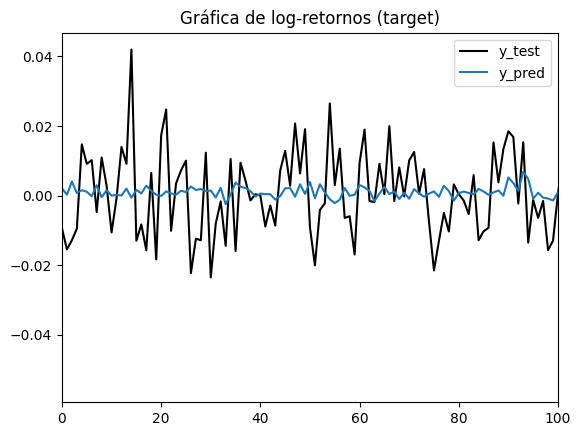

In [11]:
# Gráfica de log-retornos (target)

fig, ax = plt.subplots()
ax.plot(y_real, color='black', label='y_test')
ax.plot(y_pred, color='C0', label = 'y_pred')

# Cambio rango para ver mejor
plt.xlim([0,100])

plt.legend()
plt.title('Gráfica de log-retornos (target)')
plt.show()

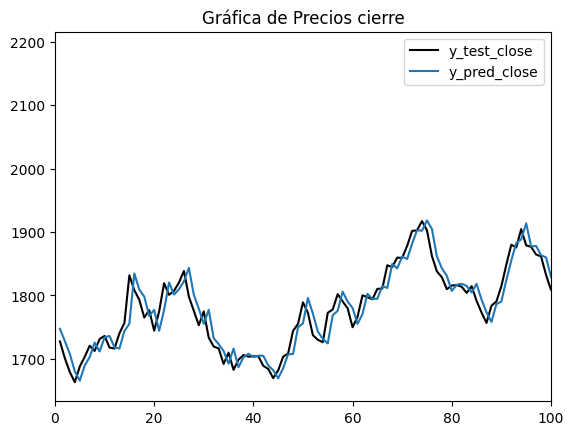

In [12]:
# Gráfica de precios cierre

fig, ax = plt.subplots()
ax.plot(y_real_close, color='black', label='y_test_close')
ax.plot(y_pred_close, color='C0', label = 'y_pred_close')

# Cambio rango para ver mejor
plt.xlim([0,100])

plt.legend()
plt.title('Gráfica de Precios cierre')
plt.show()